#1- Importing packages

In [ ]:

import os
import sys
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation,BatchNormalization
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend, layers

from __future__ import division


from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

#2- Loading and preparing the data

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load mnist data

In [ ]:
# sort and get index of each class
a = []
for i in range(0, 10):
    b = []
    for j in range(0, 60000):
        if y_train[j] == i:
            b.append(j) # each b contains indices of i class
    a.append(b)

In [ ]:
import random
rand = []
for i in range(0, 10):
  rand.append(random.choices(a[i], k=10)) # choose randomly 10 sample per class
rand = np.array(rand).flatten().tolist()

In [ ]:
x_train_lab = x_train[rand] # apply mask to get 100 random samples 
y_train_lab = y_train[rand] # 10 samples per class

In [ ]:
not_rand = [] # list of indices that dont exist in labeled data 
for i in range(0, 60_000):
    if i not in rand:
        not_rand.append(i)
not_rand = np.array(not_rand)

x_train_unlab = x_train[not_rand] # apply the mask to get the unlabled data
y_train_unlab = y_train[not_rand]


# 3- Rotation functions

In [ ]:
#Needed functions for ResNet
def angle_difference(x, y):
    """
    Calculate minimum difference between two angles.
    """
    return 180 - abs(abs(x - y) - 180)


def angle_error(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a binary vector.
    """
    diff = angle_difference(K.argmax(y_true), K.argmax(y_pred))
    return K.mean(K.cast(K.abs(diff), K.floatx()))


def angle_error_regression(y_true, y_pred):
    """
    Calculate the mean diference between the true angles
    and the predicted angles. Each angle is represented
    as a float number between 0 and 1.
    """
    return K.mean(angle_difference(y_true * 360, y_pred * 360))


def binarize_images(x):
    """
    Convert images to range 0-1 and binarize them by making
    0 the values below 0.1 and 1 the values above 0.1.
    """
    x /= 255
    x[x >= 0.1] = 1
    x[x < 0.1] = 0
    return x


def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    # No that's not an error - NumPy stores image matricies backwards
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(np.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = np.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = np.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (np.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (np.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (np.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = np.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (np.matrix(trans_mat) * np.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result


def largest_rotated_rect(w, h, angle):
    """
    Given a rectangle of size wxh that has been rotated by 'angle' (in
    radians), computes the width and height of the largest possible
    axis-aligned rectangle within the rotated rectangle.
    Original JS code by 'Andri' and Magnus Hoff from Stack Overflow
    Converted to Python by Aaron Snoswell
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    quadrant = int(math.floor(angle / (math.pi / 2))) & 3
    sign_alpha = angle if ((quadrant & 1) == 0) else math.pi - angle
    alpha = (sign_alpha % math.pi + math.pi) % math.pi

    bb_w = w * math.cos(alpha) + h * math.sin(alpha)
    bb_h = w * math.sin(alpha) + h * math.cos(alpha)

    gamma = math.atan2(bb_w, bb_w) if (w < h) else math.atan2(bb_w, bb_w)

    delta = math.pi - alpha - gamma

    length = h if (w < h) else w

    d = length * math.cos(alpha)
    a = d * math.sin(alpha) / math.sin(delta)

    y = a * math.cos(gamma)
    x = y * math.tan(gamma)

    return (
        bb_w - 2 * x,
        bb_h - 2 * y
    )


def crop_around_center(image, width, height):
    """
    Given a NumPy / OpenCV 2 image, crops it to the given width and height,
    around it's centre point
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """

    image_size = (image.shape[1], image.shape[0])
    image_center = (int(image_size[0] * 0.5), int(image_size[1] * 0.5))

    if(width > image_size[0]):
        width = image_size[0]

    if(height > image_size[1]):
        height = image_size[1]

    x1 = int(image_center[0] - width * 0.5)
    x2 = int(image_center[0] + width * 0.5)
    y1 = int(image_center[1] - height * 0.5)
    y2 = int(image_center[1] + height * 0.5)

    return image[y1:y2, x1:x2]


def crop_largest_rectangle(image, angle, height, width):
    """
    Crop around the center the largest possible rectangle
    found with largest_rotated_rect.
    """
    return crop_around_center(
        image,
        *largest_rotated_rect(
            width,
            height,
            math.radians(angle)
        )
    )


def generate_rotated_image(image, angle, size=None, crop_center=False,
                           crop_largest_rect=False):
    """
    Generate a valid rotated image for the RotNetDataGenerator. If the
    image is rectangular, the crop_center option should be used to make
    it square. To crop out the black borders after rotation, use the
    crop_largest_rect option. To resize the final image, use the size
    option.
    """
    height, width = image.shape[:2]
    if crop_center:
        if width < height:
            height = width
        else:
            width = height

    image = rotate(image, angle)

    if crop_largest_rect:
        image = crop_largest_rectangle(image, angle, height, width)

    if size:
        image = cv2.resize(image, size)

    return image


class RotNetDataGenerator(Iterator):
    """
    Given a NumPy array of images or a list of image paths,
    generate batches of rotated images and rotation angles on-the-fly.
    """

    def __init__(self, input, input_shape=None, color_mode='rgb', batch_size=64,
                 one_hot=True, preprocess_func=None, rotate=True, crop_center=False,
                 crop_largest_rect=False, shuffle=False, seed=None):

        self.images = None
        self.filenames = None
        self.input_shape = input_shape
        self.color_mode = color_mode
        self.batch_size = batch_size
        self.one_hot = one_hot
        self.preprocess_func = preprocess_func
        self.rotate = rotate
        self.crop_center = crop_center
        self.crop_largest_rect = crop_largest_rect
        self.shuffle = shuffle

        if self.color_mode not in {'rgb', 'grayscale'}:
            raise ValueError('Invalid color mode:', self.color_mode,
                             '; expected "rgb" or "grayscale".')

        # check whether the input is a NumPy array or a list of paths
        if isinstance(input, (np.ndarray)):
            self.images = input
            N = self.images.shape[0]
            if not self.input_shape:
                self.input_shape = self.images.shape[1:]
                # add dimension if the images are greyscale
                if len(self.input_shape) == 2:
                    self.input_shape = self.input_shape + (1,)
        else:
            self.filenames = input
            N = len(self.filenames)

        super(RotNetDataGenerator, self).__init__(N, batch_size, shuffle, seed)

    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros(len(index_array), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
            if self.filenames is None:
                image = self.images[j]
            else:
                is_color = int(self.color_mode == 'rgb')
                image = cv2.imread(self.filenames[j], is_color)
                if is_color:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if self.rotate:
                # get a random angle
                rotation_angle = np.random.randint(360)
            else:
                rotation_angle = 0

            # generate the rotated image
            rotated_image = generate_rotated_image(
                image,
                rotation_angle,
                size=self.input_shape[:2],
                crop_center=self.crop_center,
                crop_largest_rect=self.crop_largest_rect
            )

            # add dimension to account for the channels if the image is greyscale
            if rotated_image.ndim == 2:
                rotated_image = np.expand_dims(rotated_image, axis=2)

            # store the image and label in their corresponding batches
            batch_x[i] = rotated_image
            batch_y[i] = rotation_angle

        if self.one_hot:
            # convert the numerical labels to binary labels
            batch_y = to_categorical(batch_y, 360)
        else:
            batch_y /= 360

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)


def display_examples(model, input, num_images=5, size=None, crop_center=False,
                     crop_largest_rect=False, preprocess_func=None, save_path=None):
    """
    Given a model that predicts the rotation angle of an image,
    and a NumPy array of images or a list of image paths, display
    the specified number of example images in three columns:
    Original, Rotated and Corrected.
    """

    if isinstance(input, (np.ndarray)):
        images = input
        N, h, w = images.shape[:3]
        if not size:
            size = (h, w)
        indexes = np.random.choice(N, num_images)
        images = images[indexes, ...]
    else:
        images = []
        filenames = input
        N = len(filenames)
        indexes = np.random.choice(N, num_images)
        for i in indexes:
            image = cv2.imread(filenames[i])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            images.append(image)
        images = np.asarray(images)

    x = []
    y = []
    for image in images:
        rotation_angle = np.random.randint(360)
        rotated_image = generate_rotated_image(
            image,
            rotation_angle,
            size=size,
            crop_center=crop_center,
            crop_largest_rect=crop_largest_rect
        )
        x.append(rotated_image)
        y.append(rotation_angle)

    x = np.asarray(x, dtype='float32')
    y = np.asarray(y, dtype='float32')

    if x.ndim == 3:
        x = np.expand_dims(x, axis=3)

    y = to_categorical(y, 360)

    x_rot = np.copy(x)

    if preprocess_func:
        x = preprocess_func(x)

    y = np.argmax(y, axis=1)
    y_pred = np.argmax(model.predict(x), axis=1)

    plt.figure(figsize=(10.0, 2 * num_images))

    title_fontdict = {
        'fontsize': 14,
        'fontweight': 'bold'
    }

    fig_number = 0
    for rotated_image, true_angle, predicted_angle in zip(x_rot, y, y_pred):
        original_image = rotate(rotated_image, -true_angle)
        if crop_largest_rect:
            original_image = crop_largest_rectangle(original_image, -true_angle, *size)

        corrected_image = rotate(rotated_image, -predicted_angle)
        if crop_largest_rect:
            corrected_image = crop_largest_rectangle(corrected_image, -predicted_angle, *size)

        if x.shape[3] == 1:
            options = {'cmap': 'gray'}
        else:
            options = {}

        fig_number += 1
        ax = plt.subplot(num_images, 3, fig_number)
        if fig_number == 1:
            plt.title('Original\n', fontdict=title_fontdict)
        plt.imshow(np.squeeze(original_image).astype('uint8'), **options)
        plt.axis('off')

        fig_number += 1
        ax = plt.subplot(num_images, 3, fig_number)
        if fig_number == 2:
            plt.title('Rotated\n', fontdict=title_fontdict)
        ax.text(
            0.5, 1.03, 'Angle: {0}'.format(true_angle),
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=11
        )
        plt.imshow(np.squeeze(rotated_image).astype('uint8'), **options)
        plt.axis('off')

        fig_number += 1
        ax = plt.subplot(num_images, 3, fig_number)
        corrected_angle = angle_difference(predicted_angle, true_angle)
        if fig_number == 3:
            plt.title('Corrected\n', fontdict=title_fontdict)
        ax.text(
            0.5, 1.03, 'Angle: {0}'.format(corrected_angle),
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=11
        )
        plt.imshow(np.squeeze(corrected_image).astype('uint8'), **options)
        plt.axis('off')

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    if save_path:
        plt.savefig(save_path)

# 4- Self-supervised training of unlabeled data with Rotation Network for rotation classification

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
######NEW MODEL TEST
model=Sequential()
model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:]))
#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(360,activation="softmax"))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 256)     

In [ ]:
x_train_unlab.shape

(59900, 28, 28)

In [ ]:
######MODEL LAST TESTED WITH ACCURACY 0.5

model_name = 'rotnet_mnist'

# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
# number of classes
nb_classes = 360

nb_train_samples, img_rows, img_cols = x_train_unlab.shape
img_channels = 1
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = x_test.shape[0]

input = Input(shape=(img_rows, img_cols, img_channels))
model = Sequential()
model.add(layers.Conv2D(20,
                  [3, 3],
                  input_shape=[28, 28, 1],
                  activation='relu',
                  name='conv_1'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(50, [3, 3], activation='relu', name='conv_2'))
model.add(layers.MaxPool2D())
model.add(layers.Permute((2, 1, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(500, activation='relu', name='dense_1'))
model.add(layers.Dense(360, activation='softmax', name='dense_2'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 26, 26, 20)        200       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 20)       0         
 2D)                                                             
                                                                 
 conv_2 (Conv2D)             (None, 11, 11, 50)        9050      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 50)         0         
 2D)                                                             
                                                                 
 permute (Permute)           (None, 5, 5, 50)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1250)             

In [ ]:
# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error])

In [ ]:
model_name = 'rotnet_mnist'

# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
# number of classes
nb_classes = 360
# training parameters
batch_size = 128
nb_epoch = 50
nb_train_samples, img_rows, img_cols = x_train_unlab.shape
img_channels = 1
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = x_test.shape[0]
output_folder = 'models'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# callbacks
checkpointer = ModelCheckpoint(
    filepath=os.path.join(output_folder, model_name + '.hdf5'),
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()

# training loop
history= model.fit_generator(
    RotNetDataGenerator(
        x_train_unlab,
        batch_size=batch_size,
        preprocess_func=binarize_images,
        shuffle=True
    ),
    steps_per_epoch=nb_train_samples / batch_size,
    epochs=50,
    validation_data=RotNetDataGenerator(
        x_test,
        batch_size=batch_size,
        preprocess_func=binarize_images
    ),
    validation_steps=nb_test_samples / batch_size,
    verbose=1,
    callbacks=[checkpointer, early_stopping, tensorboard]
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
467/467 [==============================] - 102s 211ms/step - loss: 5.1535 - angle_error: 84.0525 - val_loss: 5.1816 - val_angle_error: 75.4848
Epoch 2/50
467/467 [==============================] - 90s 191ms/step - loss: 4.3415 - angle_error: 63.6930 - val_loss: 4.1735 - val_angle_error: 51.5549
Epoch 3/50
467/467 [==============================] - 89s 191ms/step - loss: 3.9519 - angle_error: 45.9332 - val_loss: 3.8889 - val_angle_error: 41.4132
Epoch 4/50
467/467 [==============================] - 90s 191ms/step - loss: 3.7212 - angle_error: 39.5994 - val_loss: 3.7996 - val_angle_error: 37.9159
Epoch 5/50
467/467 [==============================] - 89s 191ms/step - loss: 3.5933 - angle_error: 35.9965 - val_loss: 3.6571 - val_angle_error: 34.2929
Epoch 6/50
467/467 [==============================] - 89s 191ms/step - loss: 3.4897 - angle_error: 34.5507 - val_loss: 3.4446 - val_angle_error: 32.8061
Epoch 7/50
467/467 [==============================] - 89s 191ms/step - loss: 3.41

In [ ]:
batch_size = 128
out = model.evaluate_generator(
    RotNetDataGenerator(
        x_test,
        batch_size=batch_size,
        preprocess_func=binarize_images,
        shuffle=True
    ), 
    steps=len(y_test) / batch_size
)

print('Test loss:', out[0])
print('Test angle error:', out[1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  if __name__ == '__main__':


Test loss: 3.0664119720458984
Test angle error: 26.970134735107422


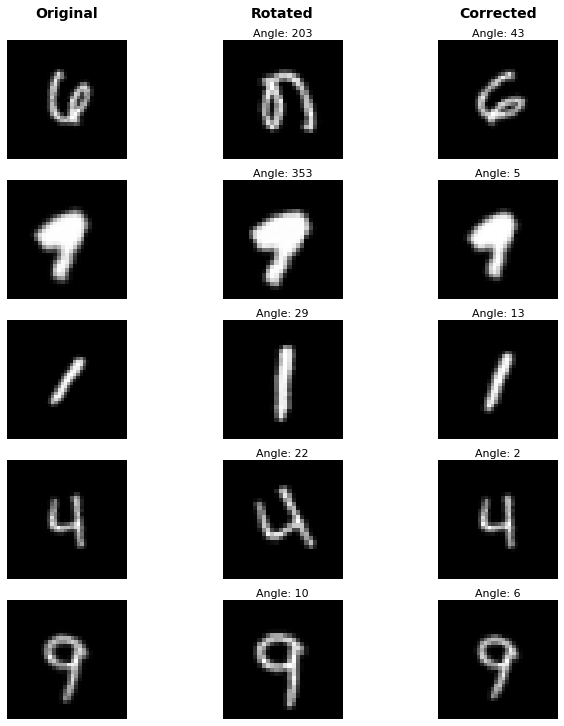

In [ ]:
num_images = 5

display_examples(
    model, 
    x_test,
    num_images=num_images,
    preprocess_func=binarize_images,
)

# 5- Supervised finetuning of labeled data using pre-trained RotNet for Mnist classification

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 10, 10, 256)     

In [ ]:
#Freezing the convolutional base of our pre-trained Rotnet
#Replacing last layer
model.trainable = False

num_targets = 10 
base_output = model.layers[-2]. output
new_output = tf.keras.layers.Dense(activation="softmax", units=num_targets)(base_output)
new_model = tf.keras.models.Model(inputs=model.inputs, outputs=new_output)
new_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4_input (InputLaye  [(None, 28, 28, 1)]      0         
 r)                                                              
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                           

In [ ]:
new_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_4_input (InputLaye  [(None, 28, 28, 1)]      0         
 r)                                                              
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 1)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 batch_normalization_12 (Bat  (None, 26, 26, 96)       384       
 chNormalization)                                                
                                                           

In [ ]:
###Do not Run for RotNEt -- Reinitialisez la session
# reshaping data to tensors since we're using CNN
x_train = x_train.reshape((60000, 28, 28, 1)).astype('float32')
y_train = to_categorical(y_train)

x_train_lab = x_train_lab.reshape((100, 28, 28, 1))
y_train_lab = to_categorical(y_train_lab)

x_test = x_test.reshape((10000, 28, 28, 1))
y_test = to_categorical(y_test)

print("x_train: ", len(x_train_lab))
print("y_train: ", len(y_train_lab))
print("x_test: ", len(x_test))
print("y_test: ", len(y_test))

x_train:  100
y_train:  100
x_test:  10000
y_test:  10000


In [ ]:
y_train_lab.shape

(100, 10)

In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history2 = new_model.fit(x_train_lab, y_train_lab, epochs=100, batch_size=120,validation_data=(x_test, y_test))

Epoch 1/100
1/1 [==============================] - 11s 11s/step - loss: 94.9141 - accuracy: 0.1300 - val_loss: 49.8955 - val_accuracy: 0.0827
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 88.4548 - accuracy: 0.0900 - val_loss: 43.4282 - val_accuracy: 0.0992
Epoch 3/100
1/1 [==============================] - 5s 5s/step - loss: 86.9067 - accuracy: 0.1000 - val_loss: 39.9188 - val_accuracy: 0.1100
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 80.7346 - accuracy: 0.1100 - val_loss: 37.8977 - val_accuracy: 0.1167
Epoch 5/100
1/1 [==============================] - 5s 5s/step - loss: 66.3662 - accuracy: 0.2000 - val_loss: 37.1485 - val_accuracy: 0.1288
Epoch 6/100
1/1 [==============================] - 5s 5s/step - loss: 79.2416 - accuracy: 0.1000 - val_loss: 36.5372 - val_accuracy: 0.1405
Epoch 7/100
1/1 [==============================] - 5s 5s/step - loss: 75.6572 - accuracy: 0.1900 - val_loss: 34.6114 - val_accuracy: 0.1542
Epoch 8/100
1/1 [=

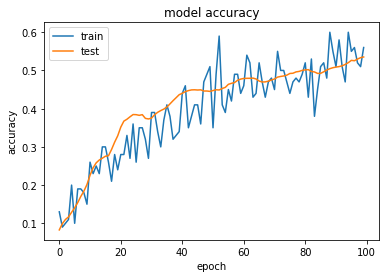

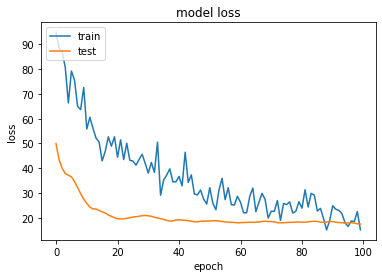

In [ ]:
# summarize history for accuracy 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


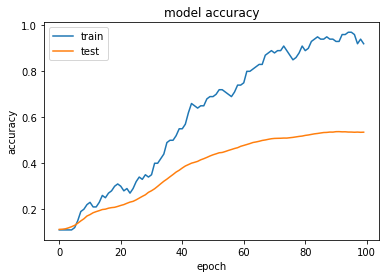

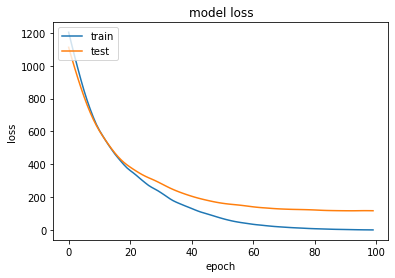

In [ ]:
# summarize history for accuracy 
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
pred = new_model(x_test)
pred = np.argmax(pred, axis=1)
y_test = to_categorical(y_test)
y_test_c = np.argmax(y_test, axis=1)


In [ ]:
# compute de confusion matrix
conf_mat = confusion_matrix(y_test_c, pred)
y_test_c.shape

ValueError: ignored

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(conf_mat, range(10), range(10))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size

# plotting the confusion matrix
plt.show()

ValueError: ignored

# 6- Supervised training of labeled data for Mnist classification

In [ ]:
model_cnn = Sequential()
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(32, (3,3), activation="relu", input_shape=(28, 28, 1))) # maxpooling layer
model_cnn.add(MaxPooling2D((2,2)))
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(64, (3,3), activation="relu"))
# maxpooling layer
model_cnn.add(MaxPooling2D((2,2)))
# convolution layer with 3x3 filter
model_cnn.add(Conv2D(64, (3,3), activation="relu"))
# flatten the layers
model_cnn.add(Flatten())
# dense layer with 256 units and relu activation
model_cnn.add(Dense(256, activation= 'relu'))
# dropout layer to keep 60% of units
model_cnn.add(Dropout(0.4))
# dense layer with 500 units and relu activation
model_cnn.add(Dense(500, activation= 'relu'))
# dropout layer to keep 40% of units
model_cnn.add(Dropout(0.6))
# dense layer with 64 units and relu activation
model_cnn.add(Dense(64, activation= 'relu'))
# dropout layer to keep 80% of units
model_cnn.add(Dropout(0.2))
# Output layer with 10 units and softmax activation
model_cnn.add(Dense(10, activation= 'softmax'))
# get summary of the model
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
# compile model with adam optimizer and categorical loss 
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the model on  training set
history = model_cnn.fit(x_train_lab, y_train_lab, epochs=100, batch_size=10,validation_data=(x_test, y_test))

Epoch 1/100
10/10 [==============================] - 4s 340ms/step - loss: 18.0083 - accuracy: 0.1000 - val_loss: 3.5697 - val_accuracy: 0.1074
Epoch 2/100
10/10 [==============================] - 5s 575ms/step - loss: 5.6691 - accuracy: 0.1100 - val_loss: 2.2572 - val_accuracy: 0.1296
Epoch 3/100
10/10 [==============================] - 5s 576ms/step - loss: 2.3659 - accuracy: 0.2200 - val_loss: 2.2146 - val_accuracy: 0.1596
Epoch 4/100
10/10 [==============================] - 3s 319ms/step - loss: 2.3667 - accuracy: 0.1600 - val_loss: 2.1621 - val_accuracy: 0.2307
Epoch 5/100
10/10 [==============================] - 5s 576ms/step - loss: 2.2104 - accuracy: 0.2100 - val_loss: 2.1154 - val_accuracy: 0.2937
Epoch 6/100
10/10 [==============================] - 5s 576ms/step - loss: 2.2120 - accuracy: 0.2000 - val_loss: 2.0485 - val_accuracy: 0.3869
Epoch 7/100
10/10 [==============================] - 5s 576ms/step - loss: 2.0778 - accuracy: 0.1800 - val_loss: 1.9906 - val_accuracy: 0.386

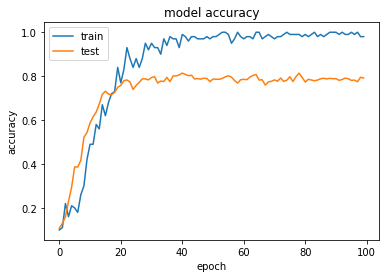

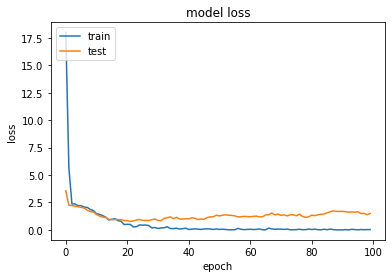

In [ ]:
# summarize history for accuracy 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
